<a href="https://colab.research.google.com/github/PaulinaPacyna/DL_speech_recognition/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import librosa
import os
os.chdir('/content/drive/MyDrive/DL3/')
import json
import pickle
import zipfile
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import pandas as pd
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation, BatchNormalization
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib.colors import LogNorm

In [3]:
if not os.path.isdir('train'):
  !pip install kaggle
  !pip install py7zr
  import py7zr
  !mkdir /root/.kaggle
  !touch /root/.kaggle/kaggle.json

  api_token = {"username":"paulinapacyna","key":"31e4c572f1ddefc96883c2195f33726b"} 

  with open('/root/.kaggle/kaggle.json', 'w') as file:
      json.dump(api_token, file)

  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle config path -p /root
  !kaggle competitions download -c tensorflow-speech-recognition-challenge
  with py7zr.SevenZipFile('train.7z', mode='r') as z:
      z.extractall()


In [4]:
def audio2mel(path):
    y, sr = librosa.core.load(path=path)
    if len(y) > sr: # we set all to have lenght equal to 1 second 
        y = y[:sr] 
    else: # pad blank
        padding = sr - len(y)
        offset = padding // 2 
        y = np.pad(y, (offset, sr - len(y) - offset), 'constant')
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    return librosa.power_to_db(mel, ref= np.max).astype(np.float) 

def convert_wav_to_image(df):
    X = []
    for _,row in tqdm(df.iterrows(), total = df.shape[0]):
        x = audio2mel(row['path'])
        X.append(x.transpose())
    X = np.array(X) 
    return X
if os.path.exists('X_train.npy') and os.path.exists('y_train.npy') and os.path.exists('class_names.npy'):
  X = np.load('X_train.npy', allow_pickle=True)
  y = np.load('y_train.npy', allow_pickle=True)
  classes = np.load('class_names.npy', allow_pickle=True)
  classes = np.array([c[3:] for c in classes])
else:
  paths = [os.path.join(dp, f) for dp, dn, fn in os.walk('train/audio') for f in fn if f[-4:]=='.wav']
  paths = pd.DataFrame(paths, columns=['path']) # .sample(n=1000).reset_index(drop=True)
  paths['label'] = paths['path'].apply(lambda x: x.split('/')[-2])
  X = convert_wav_to_image(paths)
  enc = OneHotEncoder() 
  y = enc.fit_transform(paths[['label']]).todense()
  classes = enc.get_feature_names()
  np.save('X_train.npy', X)
  np.save('y_train.npy', y)
  np.save('class_names.npy', classes)
X = (X - np.mean(X))/np.std(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [5]:
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(
    256,
    input_shape=X.shape[1:],
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam')

In [6]:
model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.3)
model.save('model')

Epoch 1/10
304/304 [==============================] - 30s 30ms/step - loss: 2.0405 - val_loss: 0.6794
Epoch 2/10
304/304 [==============================] - 8s 25ms/step - loss: 0.6160 - val_loss: 0.4965
Epoch 3/10
304/304 [==============================] - 8s 25ms/step - loss: 0.4254 - val_loss: 0.4142
Epoch 4/10
304/304 [==============================] - 8s 25ms/step - loss: 0.3158 - val_loss: 0.3409
Epoch 5/10
304/304 [==============================] - 8s 26ms/step - loss: 0.2616 - val_loss: 0.3192
Epoch 6/10
304/304 [==============================] - 8s 27ms/step - loss: 0.2224 - val_loss: 0.3155
Epoch 7/10
304/304 [==============================] - 8s 26ms/step - loss: 0.2041 - val_loss: 0.3072
Epoch 8/10
304/304 [==============================] - 8s 26ms/step - loss: 0.1775 - val_loss: 0.2939
Epoch 9/10
304/304 [==============================] - 8s 26ms/step - loss: 0.1515 - val_loss: 0.3065
Epoch 10/10
304/304 [==============================] - 8s 26ms/step - loss: 0.1446 - val_l

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [7]:
p = model.predict(X_test)
np.mean(np.argmax(p,1) == np.argmax(y_test,1))

0.922565543071161

In [8]:
pd.crosstab(classes[np.argmax(y_test,1)], classes[np.argmax(p,1)], colnames=['prediction'], rownames=['truth'])

prediction,bed,bird,cat,dog,down,eight,five,four,go,happy,house,left,marvin,nine,no,off,on,one,right,seven,sheila,six,stop,three,tree,two,up,wow,yes,zero
truth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
_background_noise_,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
bed,525,7,2,0,3,4,1,0,4,0,0,1,0,3,0,0,0,0,2,19,0,8,0,3,0,0,3,0,0,1
bird,7,509,1,0,1,0,0,0,2,0,0,0,4,0,4,0,2,0,1,4,0,0,0,0,4,1,4,0,0,0
cat,2,0,531,0,4,0,0,1,5,2,1,0,0,0,0,0,0,0,0,2,0,7,4,0,0,1,2,0,0,0
dog,1,4,0,478,27,0,5,2,16,0,0,1,0,1,9,3,5,1,0,2,0,0,5,0,0,1,2,0,0,0
down,0,0,1,5,713,0,2,0,5,0,0,0,0,3,13,1,3,4,0,6,0,2,2,0,0,1,2,4,0,1
eight,10,0,1,1,0,738,0,0,1,0,0,0,0,1,1,0,0,0,1,4,0,5,0,10,8,3,7,0,0,2
five,5,3,0,0,0,0,715,4,0,1,0,1,1,3,0,1,17,3,9,7,0,2,3,1,1,0,8,0,0,0
four,0,1,0,0,0,3,3,732,4,0,0,0,0,2,0,0,0,2,0,8,2,0,1,0,0,5,8,0,0,3


In [9]:
cross = pd.crosstab(classes[np.argmax(y_test,1)], classes[np.argmax(p,1)], colnames=['prediction'], rownames=['truth'], normalize='index')
cross

prediction,bed,bird,cat,dog,down,eight,five,four,go,happy,house,left,marvin,nine,no,off,on,one,right,seven,sheila,six,stop,three,tree,two,up,wow,yes,zero
truth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
_background_noise_,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bed,0.895904,0.011945,0.003413,0.000000,0.005119,0.006826,0.001706,0.000000,0.006826,0.000000,0.000000,0.001706,0.000000,0.005119,0.000000,0.000000,0.000000,0.000000,0.003413,0.032423,0.000000,0.013652,0.000000,0.005119,0.000000,0.000000,0.005119,0.000000,0.000000,0.001706
bird,0.012868,0.935662,0.001838,0.000000,0.001838,0.000000,0.000000,0.000000,0.003676,0.000000,0.000000,0.000000,0.007353,0.000000,0.007353,0.000000,0.003676,0.000000,0.001838,0.007353,0.000000,0.000000,0.000000,0.000000,0.007353,0.001838,0.007353,0.000000,0.000000,0.000000
cat,0.003559,0.000000,0.944840,0.000000,0.007117,0.000000,0.000000,0.001779,0.008897,0.003559,0.001779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003559,0.000000,0.012456,0.007117,0.000000,0.000000,0.001779,0.003559,0.000000,0.000000,0.000000
dog,0.001776,0.007105,0.000000,0.849023,0.047957,0.000000,0.008881,0.003552,0.028419,0.000000,0.000000,0.001776,0.000000,0.001776,0.015986,0.005329,0.008881,0.001776,0.000000,0.003552,0.000000,0.000000,0.008881,0.000000,0.000000,0.001776,0.003552,0.000000,0.000000,0.000000
down,0.000000,0.000000,0.001302,0.006510,0.928385,0.000000,0.002604,0.000000,0.006510,0.000000,0.000000,0.000000,0.000000,0.003906,0.016927,0.001302,0.003906,0.005208,0.000000,0.007812,0.000000,0.002604,0.002604,0.000000,0.000000,0.001302,0.002604,0.005208,0.000000,0.001302
eight,0.012610,0.000000,0.001261,0.001261,0.000000,0.930643,0.000000,0.000000,0.001261,0.000000,0.000000,0.000000,0.000000,0.001261,0.001261,0.000000,0.000000,0.000000,0.001261,0.005044,0.000000,0.006305,0.000000,0.012610,0.010088,0.003783,0.008827,0.000000,0.000000,0.002522
five,0.006369,0.003822,0.000000,0.000000,0.000000,0.000000,0.910828,0.005096,0.000000,0.001274,0.000000,0.001274,0.001274,0.003822,0.000000,0.001274,0.021656,0.003822,0.011465,0.008917,0.000000,0.002548,0.003822,0.001274,0.001274,0.000000,0.010191,0.000000,0.000000,0.000000
four,0.000000,0.001292,0.000000,0.000000,0.000000,0.003876,0.003876,0.945736,0.005168,0.000000,0.000000,0.000000,0.000000,0.002584,0.000000,0.000000,0.000000,0.002584,0.000000,0.010336,0.002584,0.000000,0.001292,0.000000,0.000000,0.006460,0.010336,0.000000,0.000000,0.003876


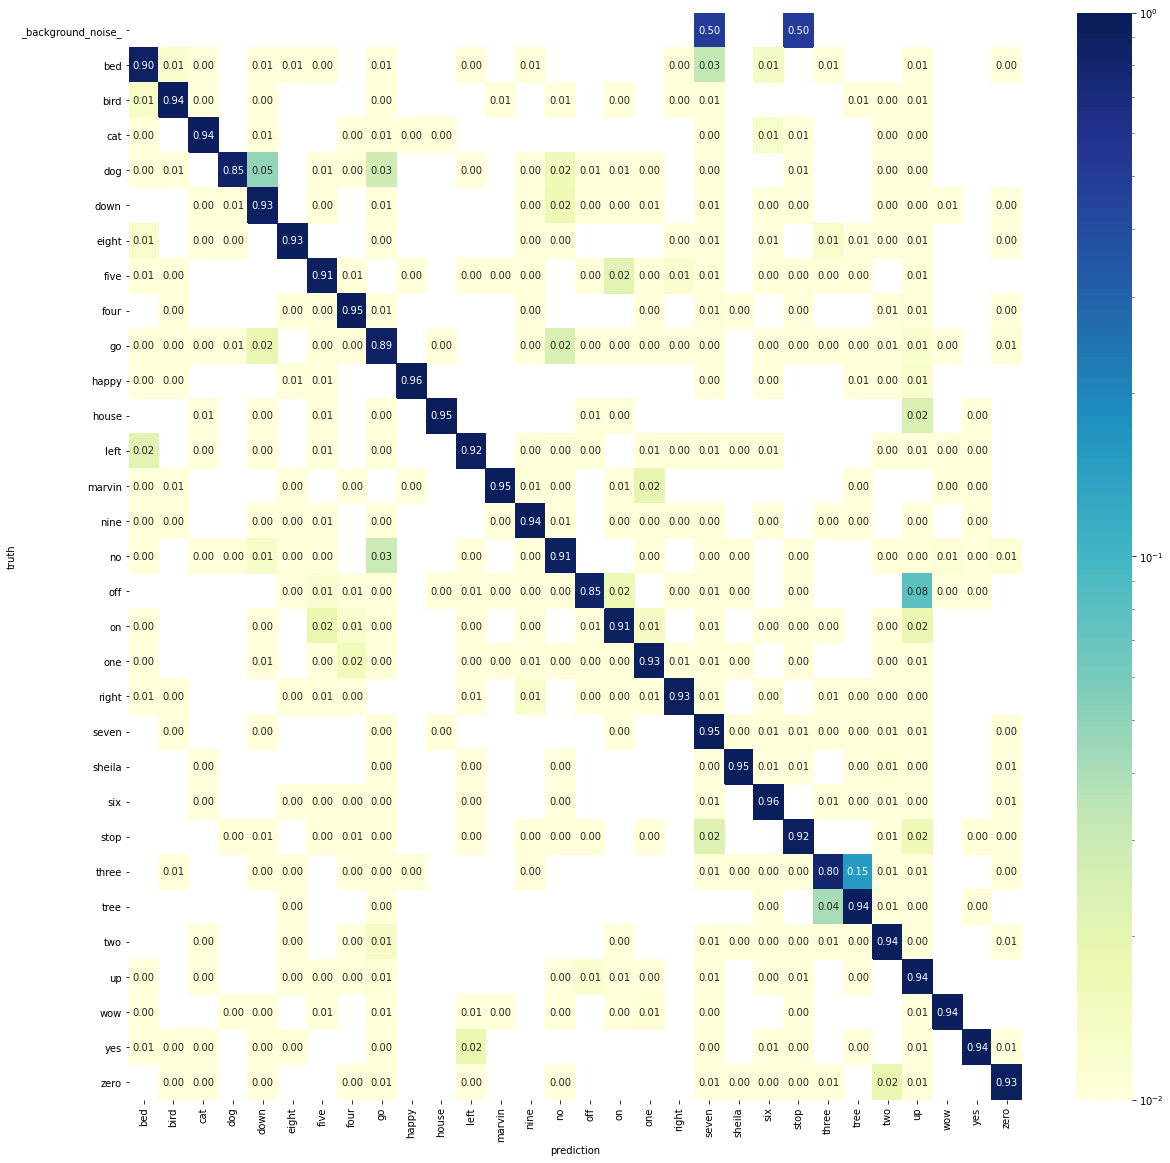

In [10]:
plt.figure(figsize=(20,20))
sns.heatmap(cross, fmt='.2f', cmap='YlGnBu', annot=True, norm=LogNorm(vmin=1e-2, vmax=1))

# Kaggle

In [3]:
if not os.path.isdir('train'):
  !pip install kaggle
  !pip install py7zr
  import py7zr
  !mkdir /root/.kaggle
  !touch /root/.kaggle/kaggle.json

  api_token = {"username":"paulinapacyna","key":"31e4c572f1ddefc96883c2195f33726b"} 

  with open('/root/.kaggle/kaggle.json', 'w') as file:
      json.dump(api_token, file)

  !chmod 600 /root/.kaggle/kaggle.json
  !kaggle config path -p /root
  !kaggle competitions download -c tensorflow-speech-recognition-challenge
  with py7zr.SevenZipFile('test.7z', mode='r') as z:
      z.extractall()

In [4]:
if os.path.exists('X_test.npy'):
  X_kaggle = np.load('X_test.npy', allow_pickle=True)  
else:
  paths = [os.path.join(dp, f) for dp, dn, fn in os.walk('test/audio') for f in fn if f[-4:]=='.wav']
  paths = pd.DataFrame(paths, columns=['path'])
  X_kaggle = convert_wav_to_image(paths) 
  np.save('X_test.npy', X_kaggle) 

In [5]:
X_kaggle= (X_kaggle-np.mean(X_kaggle))/np.std(X_kaggle)
import keras
model = keras.models.load_model('model')
kagg_pred = model.predict(X_kaggle)

In [6]:
kagg_pred = np.argmax(kagg_pred,1)
np.save('kaggle.npy', kagg_pred)

In [7]:
sumbission = pd.DataFrame([ f for dp, dn, fn in os.walk('test/audio') for f in fn if f[-4:]=='.wav'], columns=['fname'])
sumbission

,fname
0,clip_000044442.wav
1,clip_6c1d1af65.wav
2,clip_d81b3927e.wav
3,clip_6c1dc83a1.wav
4,clip_6c1dd2b7b.wav
...,...
158533,clip_6c19e22f7.wav
158534,clip_6c1be1617.wav
158535,clip_6c1c71e51.wav
158536,clip_6c1cadfc5.wav


In [8]:
classes = np.array([cl[3:] for cl in np.load('class_names.npy', allow_pickle=True)])
classes[kagg_pred]

array(['no', 'go', 'on', ..., 'six', 'nine', 'up'], dtype='<U18')

In [9]:
sumbission['label'] = classes[kagg_pred]
sumbission

,fname,label
0,clip_000044442.wav,no
1,clip_6c1d1af65.wav,go
2,clip_d81b3927e.wav,on
3,clip_6c1dc83a1.wav,one
4,clip_6c1dd2b7b.wav,seven
...,...,...
158533,clip_6c19e22f7.wav,four
158534,clip_6c1be1617.wav,four
158535,clip_6c1c71e51.wav,six
158536,clip_6c1cadfc5.wav,nine


In [10]:
sumbission.to_csv('submission.csv', index=False)